<a href="https://colab.research.google.com/github/glouwa/app-kandinsky-pattern-generator/blob/master/kandinsky_in_colab_circles_and_stars_count_red_stars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs and Files

In [1]:
!rm -r sample_data 
!wget https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py
!wget https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/master/images/parrot_cropped1.jpg

--2019-06-05 19:07:08--  https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py [following]
--2019-06-05 19:07:08--  https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5214 (5.1K) [text/plain]
Saving to: ‘lib.py’

lib.py              100%[===================>]   5.09K  --.-KB/s    in 0s      

2019-06-05 19:07:09 (83.1 MB/s) - ‘lib.py’ saved [5214/5214]

--2019-06-05 19:07:10--  https://github.com/

In [2]:
from IPython.display import display, SVG
from functools import reduce
from random import seed, randint
from numpy import array, argmax
from google.colab import widgets
import google.colab.widgets as colab_widgets
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import PIL
import json
import lib
import os 
import pickle # people say import sPickle as pickle is faster

Using TensorFlow backend.


# Intro



## Encoding
X.shape = (samples, 224, 224, 3)

Y.shape = (samples, ?)

for y we can combine multible properies of a sample. 
the output shape is defined by their amount and encodings.


In [3]:
#@title Common Stuff { vertical-output: true } 

max_count    = 6

image_shape  = (224, 224)
input_shape  = (*image_shape, 3)
output_shape = (max_count)

print('input_shape', input_shape, 'output_shape', output_shape)

usedComponents = ['enc|r◯|']
Ycomponents    = ['red ◯']
Yformat        = '%d red ◯'

Yreadable = lambda s: Yformat%s.counts['|r◯|']

compileY = lambda s: s.encoded['enc|r◯|'] 
decodeY  = lambda Y: Yformat%np.argmax(Y)
                                     
classesNotFiltered = [Yformat%r for r in range(0, max_count)]


input_shape (224, 224, 3) output_shape 6


In [0]:
max_count       = output_shape
fig_id_format   = '%s/fig%06d'
fig_path_format = './figures/%s.pkl'
png_path_format = './images/%s.png'

os.makedirs('./figures/', exist_ok=True)
os.makedirs('./images/', exist_ok=True)

def save_figure(fid, fig):    
    os.makedirs('./figures/%s'%fid.split('/')[0], exist_ok=True)
    #print("create ir", path)
    with open(fig_path_format%fid, 'wb+') as dbfile:
        pickle.dump(fig, dbfile)               

def load_figure(fid):
    with open(fig_path_format%fid, 'rb') as dbfile:
        return pickle.load(dbfile)

def load_pil(fid):
    return PIL.Image.open(png_path_format%fid).resize(image_shape, PIL.Image.LANCZOS)    

def save_pil(fid, pil):
    os.makedirs('./images/%s'%fid.split('/')[0], exist_ok=True)
    pil.save(png_path_format%(fid))

def load_image(path): # used to predict image which are not in sets (like parrot)
    return PIL.Image.open(path).resize(image_shape, PIL.Image.LANCZOS)

to_onehot    = lambda val, max_int: [1 if val == i else 0 for i in range(max_int)]
to_line_list = lambda dic:"\n\t".join("{:}: {},".format(k, v) for k, v in dic.items())
count_color  = lambda f, c: reduce(lambda a, e: a + (1 if e.color==c else 0), f, 0)
count_shape  = lambda f, c: reduce(lambda a, e: a + (1 if e.shape==c else 0), f, 0)
count_size   = lambda f, c: reduce(lambda a, e: a + (1 if e.size > c[0] and e.size <= c[1] else 0), f, 0)
count_color_and_shape  = lambda f, c, s: reduce(lambda a, e: a + (1 if e.color==c and e.shape==s else 0), f, 0)

# Sample *s*

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle', 'triangle'],
}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

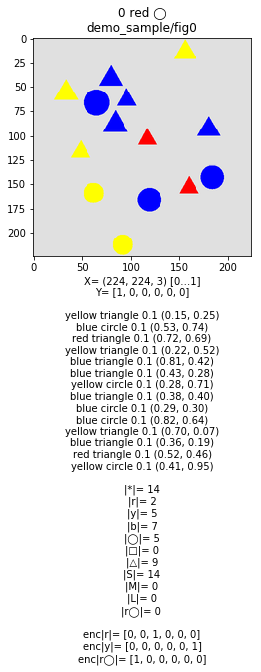

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

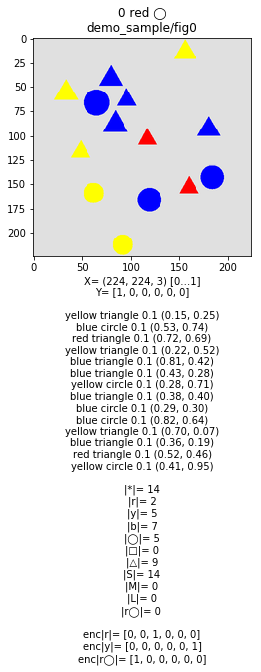

<IPython.core.display.Javascript object>

In [5]:
#@title Create a Sample { vertical-output: true }

default_figure_config = dict(   
    render_size = image_shape,
    obj_count = (2, 15),     
    obj_size = (.1, .5),
    colors = ['red','yellow', 'blue'], #['red','green', 'blue', 'yellow', 'orange'],
    shapes = ['circle', 'triangle']
)

class Sample:  
    def __init__(self, id, fig_cfg=None):
        #print('touching sample %s/%d'%(set_path, fid))        
        self.ID = id        
        self.f_config = fig_cfg
        self.f, pil = self.loadOrGenerate()            
        self.x = {            
            'fig': self.f,
            'pil': pil,
            'arr': array(pil)/255,
            #'url': pil.save(path)
        }
        self.counts = {            
            '|*|': len(self.f),
            '|r|': count_color(self.f, 'red'),
            '|y|': count_color(self.f, 'yellow'),
            '|b|': count_color(self.f, 'blue'),
            '|◯|': count_shape(self.f, 'circle'),
            '|□|': count_shape(self.f, 'rectangle'),
            '|△|': count_shape(self.f, 'triangle'),
            '|S|': count_size(self.f, (.1, .2)),
            '|M|': count_size(self.f, (.2, .4)),
            '|L|': count_size(self.f, (.4, .5)),
            '|r◯|': count_color_and_shape(self.f, 'red', 'circle'),
            
        }                
        self.encoded = {
            #'encpos':   to_onehot(self.f_config.pos, 3),            
            #'enc|*|':   to_onehot(self.counts['|*|'], max_count),            
            #'enc|yL△|': to_onehot(count large yellow triangles),
            #'enc|yS△|': to_onehot(count ),
            #'enc|y△|': to_onehot(count ),
            'enc|r|':    to_onehot(self.counts['|r|'], max_count),            
            'enc|y|':    to_onehot(self.counts['|y|'], max_count),            
            'enc|r◯|':   to_onehot(self.counts['|r◯|'], max_count),            
            #'enc|y△ left|': to_onehot(count ),
            #'enc|y△ top|': to_onehot(count ),            
            #'enc|y△ ontop r△|': to_onehot(count ),
            #'cap': []
        }        
        
        self.Yreadable = Yreadable(self)
    
    def loadOrGenerate(self):
        if os.path.isfile(fig_path_format%self.ID): self.f=load_figure(self.ID) # schnell
        else:
            self.f = lib.RandomFigure(**self.f_config)
            save_figure(self.ID, self.f)                                        # nicht so schnell
            
        if os.path.isfile(png_path_format%self.ID): pil = load_pil(self.ID)     # ok vermutlich
        else:
            pil = lib.kandinskyFigureAsImage(self.f, width=image_shape[0])      # ok
            save_pil(self.ID, pil)
        
        return self.f, pil
    
    def __str__(self):        
        return "%s"%self.ID
        
    def compileX(self):      
        return self.x['arr']    
    
    def compileY(self):        
        return compileY(self)
    
    def decodeY(self):
        return decodeY(self)
                
    def compilePandaColumns(self):
        return { 
            **{
                'ID': self.ID, 
                'file': "%s.png"%self.ID.split('/')[1],
                #'Xshape': self.x['arr'].shape, 
                'Yreadable': self.Yreadable
            },
            **self.counts,
            **self.encoded
        }
    
    def plot(self, verbose=0, title_prefix=None, X=None, Y=None):
        X = X if X is not None else self.x['arr']         
        Y = Y if Y is not None else self.compileY()        
        title_prefix = title_prefix if title_prefix is not None else self.Yreadable
        #print(title_prefix )
        fig_str =  '\n'.join([str(f) for f in self.f])
        x_dim =    '%s [%.0f…%.0f]'%(X.shape, np.min(X), np.max(X))
        counts =   '\n'.join(['%s= %s'%(k, v) for k, v in self.counts.items()])
        encoded =  '\n'.join(['%s= %s'%(k, v) for k, v in self.encoded.items()])        
        
        #plt.xlabel('\n'.join([x_dim, y_str, fig_str, counts, encoded]))
        if verbose == 0: plt.xlabel('X= %s\nY= %s'%(x_dim, Y))        
        if verbose == 1: plt.xlabel('X= %s\nY= %s\n\n%s'%(x_dim, Y, counts))        
        if verbose == 2: plt.xlabel('X= %s\nY= %s\n\n%s\n\n%s \n\n%s'%(x_dim, Y, fig_str, counts, encoded))        
            
        plt.imshow(X)
        plt.title('\n'.join([title_prefix, str(self)]))        
        plt.show()
        
print("Figure Configuration= {\n\t%s\n}"%to_line_list(default_figure_config))

grid = widgets.Grid(1, 2)
with grid.output_to(0, 0):
    example = Sample('demo_sample/fig0', default_figure_config)
    example.plot(verbose=2)        

with grid.output_to(0, 1):
    example_loaded = Sample('demo_sample/fig0', default_figure_config)
    example_loaded.plot(verbose=2)

 # Sample Set

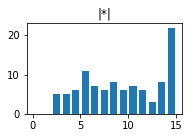

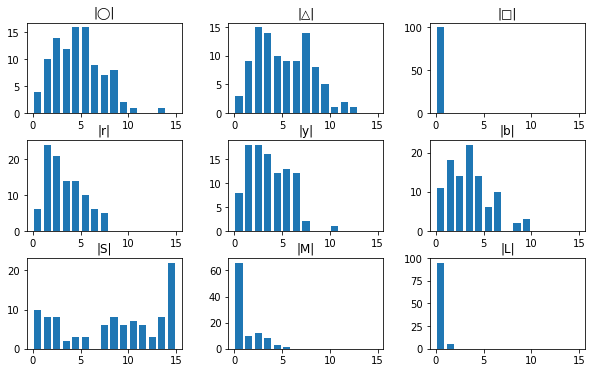

In [6]:
#@title First Batch { vertical-output: true }

def generate_batch(set_path, figure_config, batch_size, batch_idx):  
    #print('generating', n_samples)
    X = list()
    y = list()
    c = list()
    for i in range(0, batch_size):
        ID = fig_id_format%(set_path, batch_idx * batch_size + i)
        s = Sample(ID, figure_config)
        X.append(s.compileX())
        y.append(s.compileY())
        c.append({ 'BID':batch_idx, 'BPOS':i, **s.compilePandaColumns()})

    assert(len(np.array(X).shape) == 4)    
    assert(len(np.array(y).shape) == 2)
    index = pd.RangeIndex(batch_idx*batch_size, (batch_idx+1)*batch_size)
    return array(X), array(y), pd.DataFrame(index=index, data=c)
    
def sklearn_class_weight_from_vector(v):
    classes = f['Yreadable']
    return compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)

def sklearn_class_weight_from_frame(f):
    return sklearn_class_weight_from_vector(f['Yreadable'])
    
def display_batch_stats(f, fig_cfg):    
    max_objects = fig_cfg['obj_count'][1]
    args = { 
        'rwidth': .75,
        'range': (0, max_objects),
        'bins': max_objects,
        'grid': False,
        'align': 'mid' #'left', 'mid', 'right'
    }
    fig = plt.figure(figsize=(10, 6))# tight_layout=True)    
    f.hist(column='|*|', **args, ax=fig.add_subplot(331))    
    fig = plt.figure(figsize=(10, 6))
    f.hist(column='|◯|', **args, ax=fig.add_subplot(331)) # Divide into a 1x4 grid, give first section    
    f.hist(column='|△|', **args, ax=fig.add_subplot(332))
    f.hist(column='|□|', **args, ax=fig.add_subplot(333))    
    f.hist(column='|r|', **args, ax=fig.add_subplot(334))
    f.hist(column='|y|', **args, ax=fig.add_subplot(335))
    f.hist(column='|b|', **args, ax=fig.add_subplot(336))
    f.hist(column='|S|', **args, ax=fig.add_subplot(337))
    f.hist(column='|M|', **args, ax=fig.add_subplot(338))
    f.hist(column='|L|', **args, ax=fig.add_subplot(339))
        
_, _, f = generate_batch('view_batch', default_figure_config, 100, 0)    
display_batch_stats(f, default_figure_config)

In [0]:
# https://github.com/keras-team/keras/issues/12586
from tensorflow.python.keras.utils.data_utils import Sequence

class DataGenerator(Sequence):
#class DataGenerator(keras.utils.Sequence):  
    'Generates kandinsky data for Keras'
    def __init__(self, set_path="err", samples=1000, batch_size=32, in_dim=None, out_dim=None, figure_parameters=None):        
        self.set_path = set_path
        self.figure_parameters = figure_parameters
        self.n_samples = samples        
        self.batch_size = batch_size        
        self.in_dim = in_dim                
        self.out_dim = out_dim
        
    def __len__(self):
        'Denotes the number of batches per epoch'        
        return int(np.floor(self.n_samples / self.batch_size))

    def __getitem__(self, idx):         
        X, y, f = generate_batch(self.set_path, self.figure_parameters, self.batch_size, idx)                
        return X, y
    
    def renderFrame(self):
        panda = pd.DataFrame()
        for idx in range(len(self)):
            X, y, f = generate_batch(self.set_path, self.figure_parameters, self.batch_size, idx)        
            panda = panda.append(f)    
        print(len(self), self.set_path, "Batches touched (%s)"%self.set_path)
        self.panda = PandaSet(panda, self)
        return self
    
class PandaSet:        
    def __init__(self, f, source_generator, rowidx_sync_generator=None):
        "bound to the generator which created the data by BID and BPOS"
        self.f = f
        self.source_generator = source_generator
        self.generator = rowidx_sync_generator or source_generator        
        self.class_weight = sklearn_class_weight_from_frame(self.f)        
       
    def display_meta(self, fig_cfg):                                            ## about the whole set
        "all abount the set properties"               
        print("\nshape=", self.f.shape)
        t = colab_widgets.TabBar(["Info", "Plots"])    
        with t.output_to(0):
            print("Figure Configuration= {\n\t%s\n}"%to_line_list(fig_cfg))
            print("\nMax |r| in training set=", np.max(self.f['|r|'] + 1))
            print("\nClass names=", np.unique(self.f['Yreadable'])) 
            print("\nsklearn classweights= ", self.class_weight)
            print("\nPanda info=")
            self.f.info()            
        with t.output_to(1): 
            display_batch_stats(self.f, fig_cfg) 

    def display_content_slice(self, slicePanda, sample_view=lambda s, r: s.plot(verbose=1), assert_view=None):               ## just a slice of it
        "show samples in detail"
        "by slice of panda"
        def display_XY():
            visible_samples = slicePanda.stop - slicePanda.start
            grid = colab_widgets.Grid(visible_samples, 2)            
            for i, (row_idx, sample_row) in enumerate(self.f.iloc[slicePanda].iterrows()):
                BID = sample_row['BID']
                BPOS = sample_row['BPOS']
                batch = self.generator[BID]                
                with grid.output_to(i, 0): display(batch[0][BPOS])
                with grid.output_to(i, 1): display(batch[1][BPOS])
        def display_sample():
            grid = colab_widgets.Grid(2, slicePanda.stop - slicePanda.start)
            for i, (row_idx, sample_row) in enumerate(self.f.iloc[slicePanda].iterrows()):
                ID = sample_row['ID']
                sample = Sample(ID, default_figure_config)                
                with grid.output_to(0, i):
                    sample_view(sample, sample_row) 
                with grid.output_to(1, i):
                    if assert_view:                        
                        assert_view(sample, sample_row, row_idx, self.generator, self.source_generator)
        
        t = colab_widgets.TabBar(["Panda", "Encoded X and Y", "Sample View"])        
        with t.output_to("Panda"): display(self.f.iloc[slicePanda])             # panda slice  
        with t.output_to("Encoded X and Y"): display_XY()                       # X and Y encoded            
        with t.output_to("Sample View"): display_sample()            

# Creating Training Data

And cerates the images and figure files

571 train Batches touched (train)
47 valid Batches touched (valid)

shape= (11991, 19)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle', 'triangle'],
}

Max |r| in training set= 12

Class names= ['0 red ◯' '1 red ◯' '2 red ◯' '3 red ◯' '4 red ◯' '5 red ◯' '6 red ◯'
 '7 red ◯' '8 red ◯']

sklearn classweights=  [0.69444444 0.41666667 0.75757576 2.08333333 5.55555556 5.55555556]

Panda info=
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11991 entries, 0 to 11990
Data columns (total 19 columns):
BID          11991 non-null int64
BPOS         11991 non-null int64
ID           11991 non-null object
Yreadable    11991 non-null object
enc|r|       11991 non-null object
enc|r◯|      11991 non-null object
enc|y|       11991 non-null object
file         11991 non-null object
|*|          11991 non-null int64
|L|          11991 non-null int64
|M|          11991 non-null int64
|S|          11991 non-null int64
|b|          11991 non-null int64
|r|          11991 non-null int64
|r◯

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

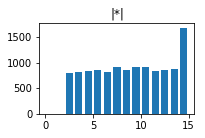

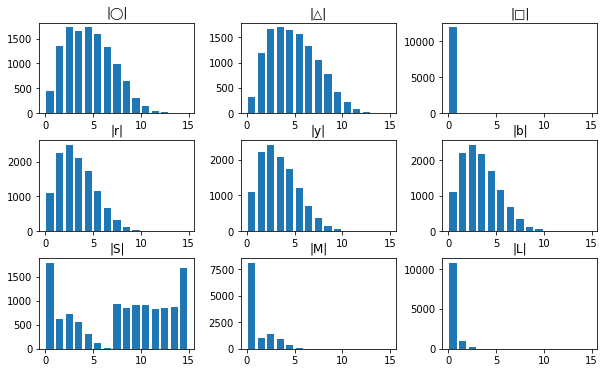

<IPython.core.display.Javascript object>

CPU times: user 3min 1s, sys: 4.27 s, total: 3min 5s
Wall time: 3min 4s


In [8]:
#@title Create Training/Validation Set. Show Training Set (f, fig_cfg) { vertical-output: true }
%%time

batch_size      = 21 #@param {type:"slider", min:1, max:200, step:5}
training_size   = 12000 #@param {type:"slider", min:100, max:20000, step:100}
validation_size = 1000 #@param {type:"slider", min:100, max:1500, step:10}

params = {
    'figure_parameters': default_figure_config,
    'batch_size': batch_size,
    'in_dim': input_shape,
    'out_dim': output_shape
}

training_generator = DataGenerator(set_path="train", samples=training_size, **params).renderFrame()
validation_generator = DataGenerator(set_path="valid", samples=validation_size, **params).renderFrame()

training_generator.panda.display_meta(params['figure_parameters'])



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

BID  BPOS               ID Yreadable  ... |y| |□| |△| |◯|
9     0     9  train/fig000009   1 red ◯  ...   1   0   2   2
10    0    10  train/fig000010   1 red ◯  ...   1   0   3   3
11    0    11  train/fig000011   0 red ◯  ...   0   0   3   1
12    0    12  train/fig000012   1 red ◯  ...   3   0   3   2
13    0    13  train/fig000013   0 red ◯  ...   0   0   4   1
14    0    14  train/fig000014   0 red ◯  ...   2   0   2   5
15    0    15  train/fig000015   1 red ◯  ...   5   0   4   6
16    0    16  train/fig000016   1 red ◯  ...   6   0   7   5
17    0    17  train/fig000017   0 red ◯  ...   1   0   2   0
18    0    18  train/fig000018   2 red ◯  ...   2   0   5   2
19    0    19  train/fig000019   1 red ◯  ...   5   0   4   9
20    0    20  train/fig000020   0 red ◯  ...   3   0   3   2
21    1     0  train/fig000021   2 red ◯  ...   4   0   3   6
22    1     1  train/fig000022   1 red ◯  ...   1   0   2   1
23    1     2  train/fig000023   2 red ◯  ...   7   0   9   4
24    1     3  train/fig000024   2 red ◯  ...   0   0   1   3
25    1     4  train/fig000025   0 red ◯  ...   1   0   5   1
26    1     5  train/fig000026   0 red ◯  ...   2   0   2   3
27    1     6  train/fig000027   1 red ◯  ...   3   0   7   3
28    1     7  train/fig000028   1 red ◯  ...   1   0   6   2

[20 rows x 19 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

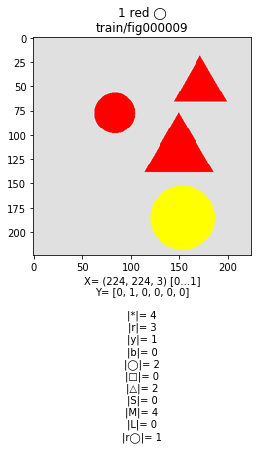

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

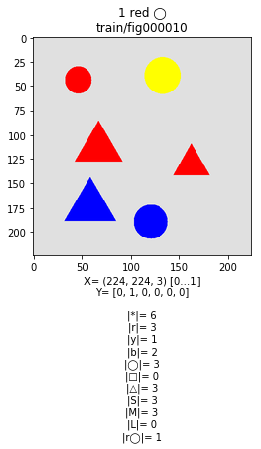

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

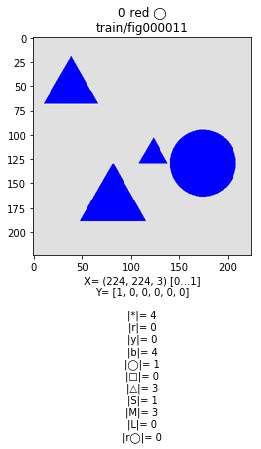

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

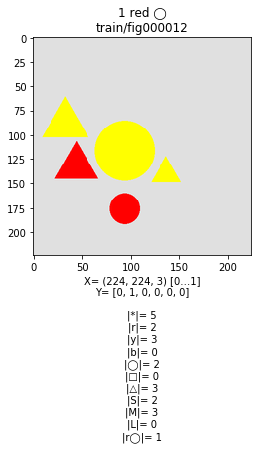

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

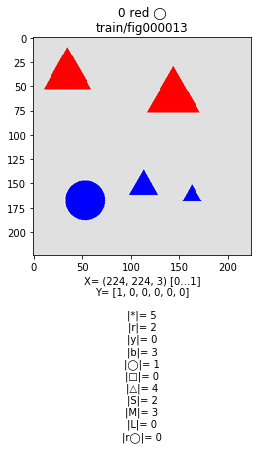

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

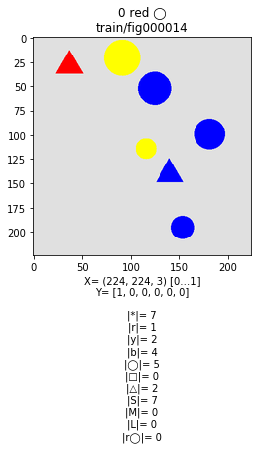

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

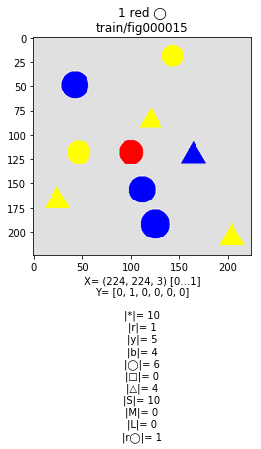

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

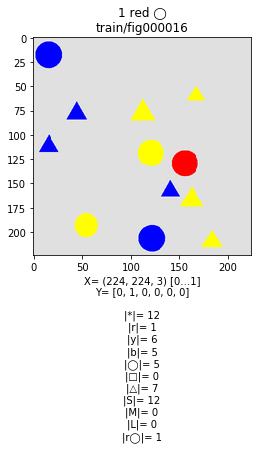

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

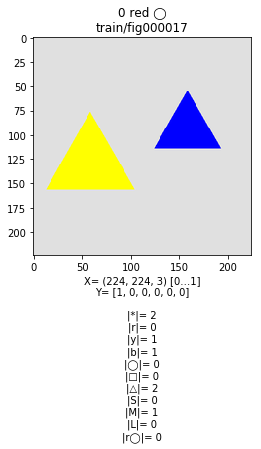

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

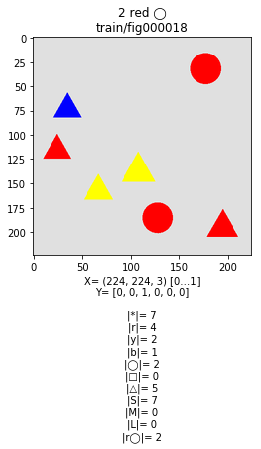

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

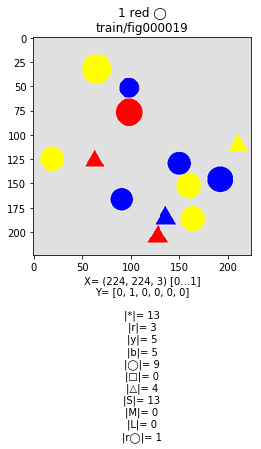

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

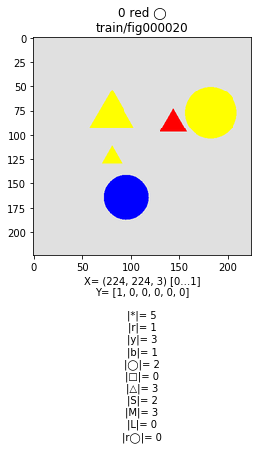

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

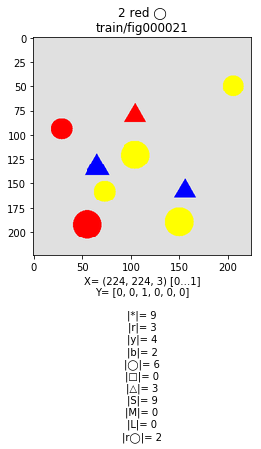

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

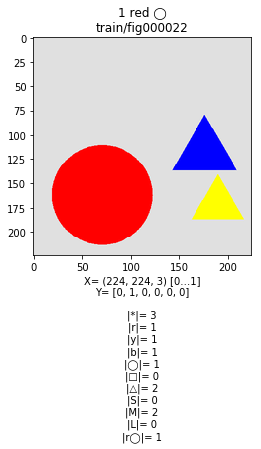

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

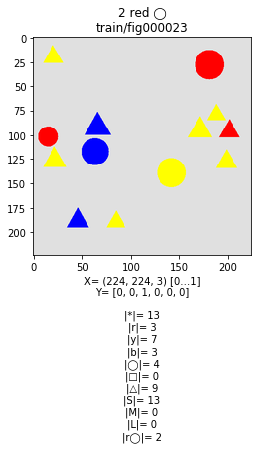

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

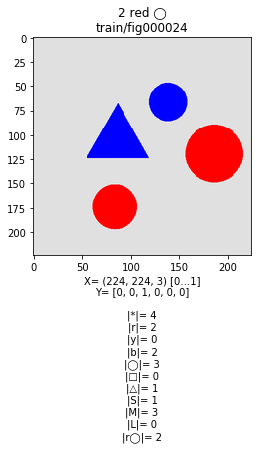

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

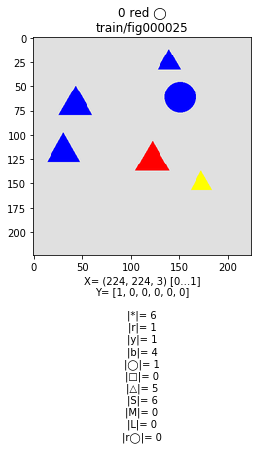

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

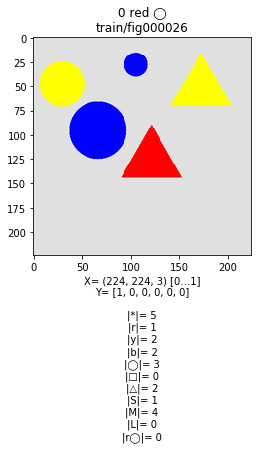

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

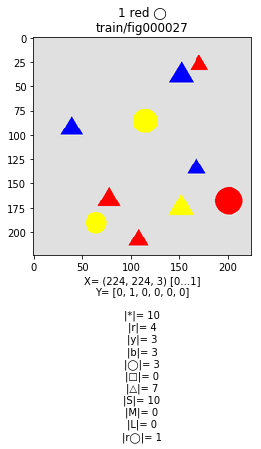

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

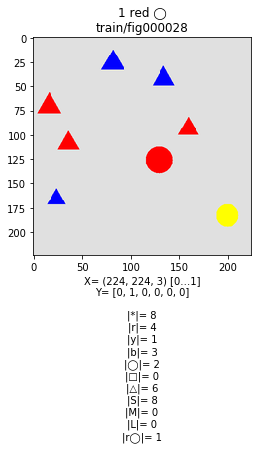

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
#@title Review Training Generator Content (X, Y, f) (Sample View) { run: "auto", vertical-output: true }

sample_to_view  = 9 #@param {type:"slider", min:0, max:20000, step:1}
view_len = 20 #@param {type:"slider", min:1, max:20, step:1}

training_generator.panda.display_content_slice(slice(sample_to_view, sample_to_view + view_len))



In [10]:
#@title Second time sould be Faster. (images are already cached) { vertical-output: true }
%%time

training_generator = DataGenerator(set_path="train", samples=training_size,   **params).renderFrame()
validation_generator = DataGenerator(set_path="valid", samples=validation_size, **params).renderFrame()

571 train Batches touched (train)
47 valid Batches touched (valid)
CPU times: user 30.9 s, sys: 1.31 s, total: 32.2 s
Wall time: 32.2 s


# Just for Fun: Remove some Samples from Training Set


shape= (11940, 19)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle', 'triangle'],
}

Max |r| in training set= 12

Class names= ['0 red ◯' '1 red ◯' '2 red ◯' '3 red ◯' '4 red ◯' '5 red ◯']

sklearn classweights=  [0.69444444 0.41666667 0.75757576 2.08333333 5.55555556 5.55555556]

Panda info=
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11940 entries, 0 to 11990
Data columns (total 19 columns):
BID          11940 non-null int64
BPOS         11940 non-null int64
ID           11940 non-null object
Yreadable    11940 non-null object
enc|r|       11940 non-null object
enc|r◯|      11940 non-null object
enc|y|       11940 non-null object
file         11940 non-null object
|*|          11940 non-null int64
|L|          11940 non-null int64
|M|          11940 non-null int64
|S|          11940 non-null int64
|b|          11940 non-null int64
|r|          11940 non-null int64
|r◯|         11940 non-null int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

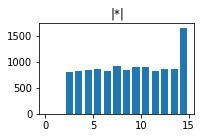

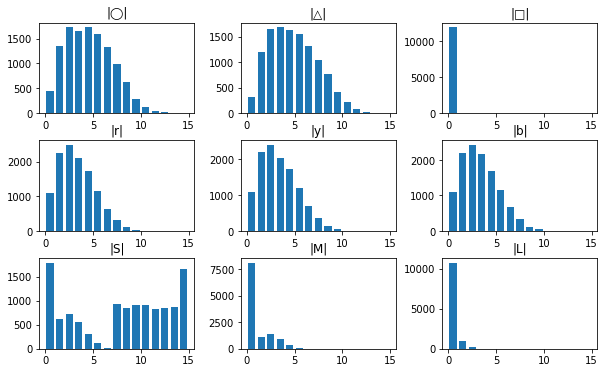

<IPython.core.display.Javascript object>

In [11]:
#@title Select Classes (training_panda → training_panda_filterd) { vertical-output: true }

def filter_panda(panda):
    return panda.loc[panda['Yreadable'].isin(classesNotFiltered)]

view_filtered = PandaSet(
    filter_panda(training_generator.panda.f), 
    None
)

view_filtered.display_meta(params['figure_parameters'])

# Generator Chain

In [0]:
from keras.preprocessing.image import ImageDataGenerator

argumented_training_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 180,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = [1, 1.5],
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)
argumented_validation_generator = ImageDataGenerator(rescale=1./255)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

BID  BPOS               ID Yreadable  ... |y| |□| |△| |◯|
0    0     0  train/fig000000   1 red ◯  ...   2   0   3   4
1    0     1  train/fig000001   0 red ◯  ...   2   0   1   1
2    0     2  train/fig000002   4 red ◯  ...   7   0   7   8

[3 rows x 19 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 1, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

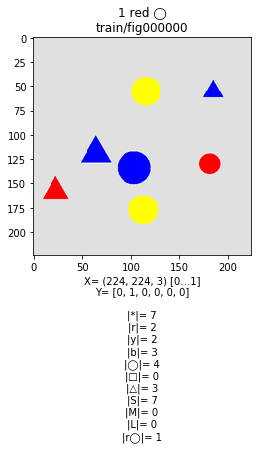

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

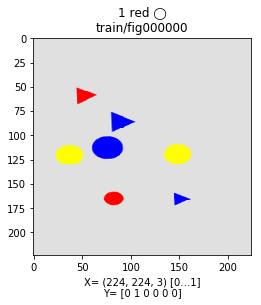

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

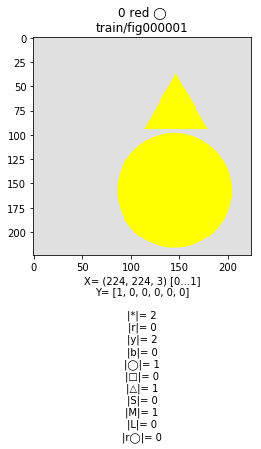

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

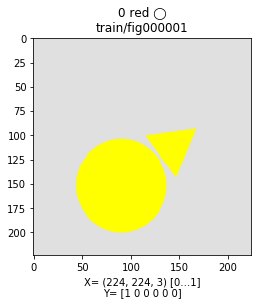

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

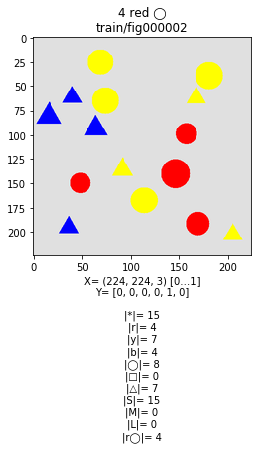

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

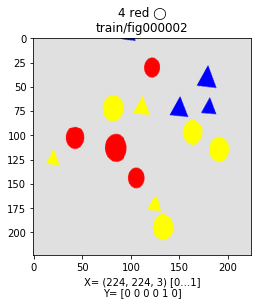

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
#@title Data Augmentation and Y Declaration { vertical-output: true }

class AugmentationGenerator(Sequence): # same element count, but transformed elements
    def __init__(self, decorated):        
        self.decorated = decorated
        self.batch_size = decorated.batch_size
        self.last_batch_id = None
        
    def __len__(self):        
        return len(self.decorated)

    def __getitem__(self, idx):         
        X, Y, = self.getBatchCached(idx)
        for i in range(len(X)):        
            X[i] = argumented_training_generator.random_transform(X[i])            
        return X, Y
    
    def getBatchCached(self, idx):
        if not self.last_batch_id or self.last_batch_id != idx:
            self.last_batch = self.decorated[idx]
            self.last_batch_id = idx
        return self.last_batch
    
class FilterByFrameGenerator(Sequence): # filters elements
    def __init__(self, decorated, panda_frame):        
        self.decorated = decorated
        self.batch_size = decorated.batch_size
        self.panda_frame = panda_frame
        self.last_batch_id = None
        
    def __len__(self):        
        return int(len(self.panda_frame) / self.batch_size)

    def __getitem__(self, idx):
        batch_panda = self.panda_frame.iloc[idx*self.batch_size : (idx+1)*self.batch_size]
        X = list()
        Y = list()
        last_batch_id = None
        for i, (row_idx, sample_row) in enumerate(batch_panda.iterrows()):
            current_batch_id = sample_row['BID']   
            current_batch_pos = sample_row['BPOS']            
            batch = self.getBatchCached(current_batch_id)
            X.append(batch[0][current_batch_pos])
            Y.append(batch[1][current_batch_pos])
        
        return np.array(X), np.array(Y)
    
    def getBatchCached(self, idx):
        if not self.last_batch_id or self.last_batch_id != idx:
            self.last_batch = self.decorated[idx]
            self.last_batch_id = idx
        return self.last_batch
    
fpt = filter_panda(training_generator.panda.f)
training_filtered = PandaSet(
    fpt, 
    training_generator,
    rowidx_sync_generator = FilterByFrameGenerator(training_generator, fpt)
)
training_augmented = PandaSet(
    training_filtered.f, 
    training_generator,
    rowidx_sync_generator = AugmentationGenerator(training_filtered.generator)
)
training_augmented.display_content_slice(
    slice(0, 3),
    assert_view = lambda s, r, ridx, g, sg: s.plot(
        X=g[int(ridx/g.batch_size)][0][ridx%g.batch_size], # brauche sample von  training_augmented.generator
        Y=g[int(ridx/g.batch_size)][1][ridx%g.batch_size], 
        #X=sg[r['BID']][0][r['BPOS']], 
        #Y=sg[r['BID']][1][r['BPOS']]
    )
)

fpv = filter_panda(validation_generator.panda.f)    
validation_filtered = PandaSet(
    fpv,
    validation_generator,
    rowidx_sync_generator = FilterByFrameGenerator(validation_generator, fpv)
)
validation_augmented = PandaSet(
    validation_filtered.f, 
    validation_generator,
    rowidx_sync_generator = AugmentationGenerator(validation_filtered.generator)
)

# Data ready - Load  VGG16

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 36s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__

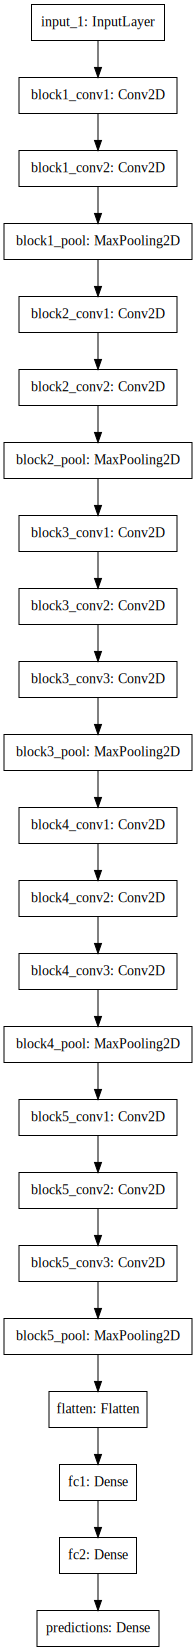

In [14]:
#@title Download VGG16 { vertical-output: true, output-height: 400 }

vgg16_init_weights = 'imagenet' #@param ["'imagenet'", "None"] {type:"raw"}

from tensorflow.python.keras.applications import VGG16

vgg16model = VGG16(include_top=True, weights=vgg16_init_weights)
vgg16model.summary()
SVG(keras.utils.vis_utils.model_to_dot(vgg16model).create(prog='dot', format='svg'))

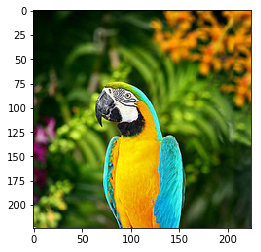

40960/35363 [==================================] - 0s 8us/step
79.02% : macaw
 6.61% : bubble
 3.64% : vine_snake
 1.90% : pinwheel
 1.22% : knot


In [15]:
#@title Make a prediction with vgg16 imagenet weights{ vertical-output: true }

from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions

def predict(image_array):
    plt.imshow(image_array)
    plt.show()
    
    img_array = np.expand_dims(image_array, axis=0)   
    
    pred = vgg16model.predict(img_array)
    pred_decoded = decode_predictions(pred)[0]
    
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))  
        
predict(load_image('parrot_cropped1.jpg'))
#predict(image_path=image_paths_train[0])

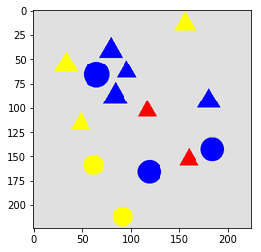

 8.57% : envelope
 3.96% : mosquito_net
 2.64% : shower_curtain
 2.05% : toilet_tissue
 2.00% : tray


In [16]:
#@title predict a Kandinsky Figure with VGG16 imagenet weights { vertical-output: true }
predict(example.x['arr'])

# Creating a Model: VGG16[0:block5_pool] + 2 new Dense Layers

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 40,411,974
Trainable params: 40,411,974
Non-trainable params: 0
_________________________________________________________________


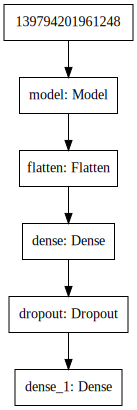

In [17]:
#@title Creating a new Model { vertical-output: true, output-height: 300 }
n1           = 100 #@param {type:"slider", min:1, max:500, step:1}
n2           = 50 #@param {type:"slider", min:1, max:500, step:1}

from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.optimizers import Adam, RMSprop

conv_model = Model(inputs=vgg16model.input, outputs=vgg16model.get_layer('block5_pool').output)

new_model = Sequential()
new_model.add(conv_model)
new_model.add(Flatten())
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(output_shape, activation='softmax'))

new_model.summary()
SVG(keras.utils.vis_utils.model_to_dot(new_model).create(prog='dot', format='svg'))

# Training

In [0]:
#used_training_generator = training_generator                   # the unfiltered first DataGenerator 
#used_training_generator = training_filtered.generator
used_training_generator = training_augmented.generator

class_weight = training_filtered.class_weight

#used_validation_generator = validation_filtered.generator
used_validation_generator = validation_augmented.generator


Raw: len=568, batch_size=21


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

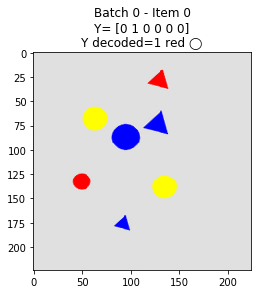

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

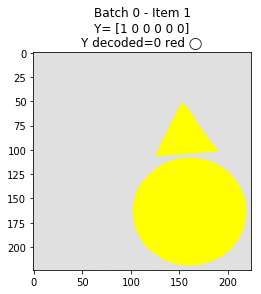

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

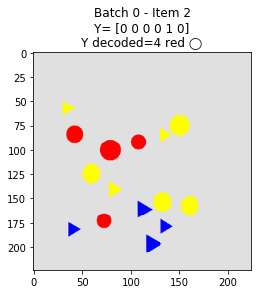

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

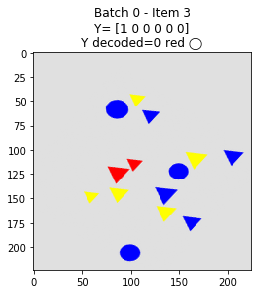

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

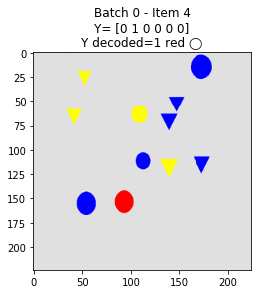

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

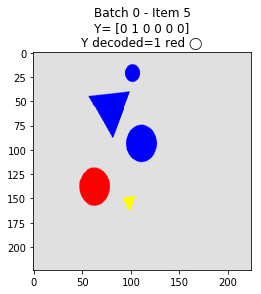

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

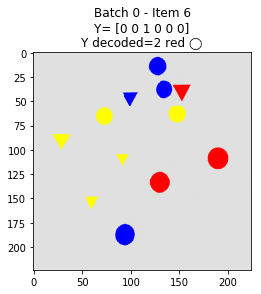

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

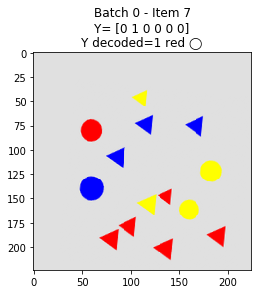

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

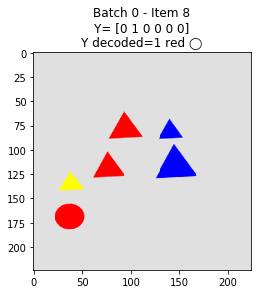

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

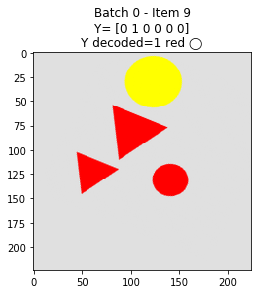

<IPython.core.display.Javascript object>

In [19]:
def show_batches(name, generator):    
    print("\n%s: len=%d, batch_size=%d"%(name, len(generator), generator.batch_size))
    #generator.reset()?
    
    batch_to_view = 0 #@param {type:"slider", min:0, max:100, step:3}
    batch_view_len = 10 #@param {type:"slider", min:1, max:20, step:1}
    
    X = generator[batch_to_view][0]
    Y = generator[batch_to_view][1]
    
    image_count = min(batch_view_len, generator.batch_size)
    
    grid = widgets.Grid(1, batch_view_len)
    for i in range(image_count):
        with grid.output_to(0, i):        
            plt.title('Batch %d - Item %d\nY= %s\nY decoded=%s'%(batch_to_view, i, Y[i], Sample.decodeY(Y[i])))
            # assert X = Sample(id=batch*batch_size+i).X
            plt.imshow(X[i])
            plt.show()

show_batches('Raw', used_training_generator)


In [20]:
#@title Compile after trainable Layers are set { vertical-output: true }
optimizer     = "adam"                     #@param ["adam" ,"other"]
learning_rate = 0.01                       #@param {type:"slider", min:1e-7, max:0.01, step:1e-3}
loss          = "categorical_crossentropy" #@param ["categorical_crossentropy", "whatever"]
main_metric   = "categorical_accuracy"     #@param ["accuracy", "categorical_accuracy"]
train_vgg16   = True #@param {type:"boolean"}

print(' '.join([str(layer.trainable) for layer in conv_model.layers]), '\n')

conv_model.trainable = train_vgg16
for layer in conv_model.layers: layer.trainable = train_vgg16
    
new_model.compile(
    optimizer = Adam(lr=1e-5), 
    loss = loss, 
    metrics = [main_metric]
)

print(' '.join([str(layer.trainable) for layer in conv_model.layers]), '\n')


True True True True True True True True True True True True True True True True True True True 

True True True True True True True True True True True True True True True True True True True 



batch_size= 21 batch_count= 568 samples*= 11928 
epochs= 2 steps_per_epoch= 112 samples_per_step*= 106
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
568/568 [==============================] - 262s 461ms/step - loss: 0.7153 - categorical_accuracy: 0.7094 - val_loss: 0.1540 - val_categorical_accuracy: 0.9565
Epoch 2/2
568/568 [==============================] - 256s 450ms/step - loss: 0.1668 - categorical_accuracy: 0.9489 - val_loss: 0.0729 - val_categorical_accuracy: 0.9886


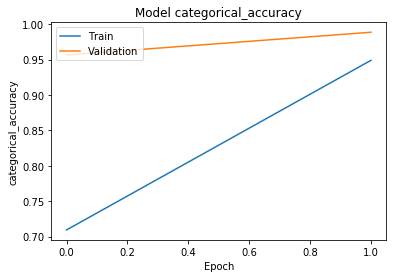

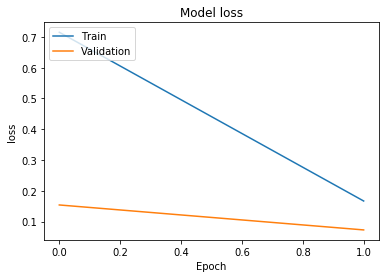

categorical_accuracy = 0.9489437
val_categorical_accuracy = 0.98861283
CPU times: user 11min 40s, sys: 2min 5s, total: 13min 46s
Wall time: 8min 41s
Parser   : 133 ms


In [21]:
#@title Training { vertical-output: true }
%%time

steps_per_epoch    = 112 #@param {type:"slider", min:10, max:500, step:1}
epochs             = 2 #@param {type:"slider", min:1, max:50, step:1}
learning_rate      = 30 #@param {type:"slider", min:1, max:50, step:1}
trained_layers     = 'dense' #@param ["'all'", "'dense'", "'vgg16[5,6]'"] {type:"raw"}
use_multprocessing = False #@param {type:"boolean"}
workers            = 8 #@param {type:"slider", min:1, max:64, step:1}
verbose            = 1 #@param {type:"slider", min:0, max:5, step:1}

print(
    "batch_size=", used_training_generator.batch_size, 
    "batch_count=", len(used_training_generator), 
    "samples*=", used_training_generator.batch_size * len(used_training_generator), 
    "\nepochs=", epochs, 
    "steps_per_epoch=", steps_per_epoch, 
    "samples_per_step*=", int(used_training_generator.batch_size * len(used_training_generator) 
                              / steps_per_epoch)
)

fit_result1 = new_model.fit_generator(    
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,    
    
    generator = used_training_generator,  
    validation_data = used_validation_generator,
    
    class_weight = class_weight,
    #use_multiprocessing = use_multprocessing,    
    #workers = workers,
    verbose = verbose
)

def plot_metric(history, m):        
        plt.plot(history[m])
        plt.plot(history['val_%s'%m])
        plt.title('Model %s'%m)
        plt.ylabel(m)
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    
def plot_history(history):    
    plot_metric(history, main_metric)
    plot_metric(history, 'loss')
    print(main_metric,          "=", history[main_metric][-1])
    print("val_%s"%main_metric, "=", history["val_%s"%main_metric][-1])

#history_merge =  merge_history(history_merge, fit_result2.history) if history_merge else fit_result1.history
history_merge = fit_result1.history
plot_history(history_merge)

Epoch 1/6
568/568 [==============================] - 259s 456ms/step - loss: 0.0993 - categorical_accuracy: 0.9712 - val_loss: 0.0683 - val_categorical_accuracy: 0.9886
Epoch 2/6
568/568 [==============================] - 255s 449ms/step - loss: 0.0822 - categorical_accuracy: 0.9800 - val_loss: 0.0923 - val_categorical_accuracy: 0.9731
Epoch 3/6
568/568 [==============================] - 255s 449ms/step - loss: 0.0743 - categorical_accuracy: 0.9832 - val_loss: 0.0616 - val_categorical_accuracy: 0.9876
Epoch 4/6
568/568 [==============================] - 255s 448ms/step - loss: 0.0558 - categorical_accuracy: 0.9869 - val_loss: 0.0375 - val_categorical_accuracy: 0.9886
Epoch 5/6
568/568 [==============================] - 255s 448ms/step - loss: 0.0567 - categorical_accuracy: 0.9886 - val_loss: 0.0606 - val_categorical_accuracy: 0.9917
Epoch 6/6
568/568 [==============================] - 254s 447ms/step - loss: 0.0601 - categorical_accuracy: 0.9885 - val_loss: 0.0280 - val_categorical_acc

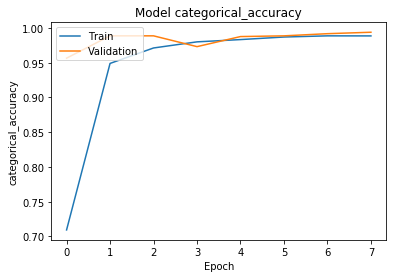

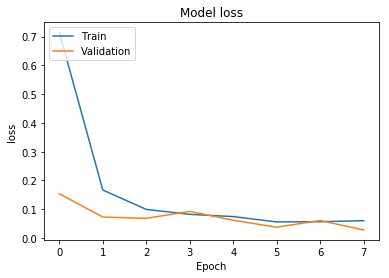

categorical_accuracy = 0.9885144
val_categorical_accuracy = 0.99378884
CPU times: user 34min 27s, sys: 6min 13s, total: 40min 41s
Wall time: 25min 31s


In [22]:
#@title Training { vertical-output: true }
%%time

epochs             = 6 #@param {type:"slider", min:1, max:50, step:1}
learning_rate      = 2 #@param {type:"slider", min:1, max:50, step:1}
trained_layers     = 'all' #@param ["'all'", "'vgg16'", "'vgg16[5,6]'"] {type:"raw"}

fit_result2 = new_model.fit_generator(    
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,    
    
    generator = used_training_generator,  
    validation_data = used_validation_generator,
    
    class_weight = class_weight,
    #use_multiprocessing = use_multprocessing,    
    #workers = workers,
    verbose = verbose
)

print(main_metric, "=", fit_result2.history[main_metric][-1])

def merge_history(h1, h2):
    assert(h1.keys() == h2.keys())
    history_merge_values = list(map(lambda ek: h1[ek] + h2[ek], h1.keys()))
    return dict(zip(h1.keys(), history_merge_values)) 
    
history_merge = merge_history(history_merge, fit_result2.history)    
plot_history(history_merge)

# Checkpoint

In [23]:
from keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive_path = '/content/drive/My Drive/colab/kandinsky/'
model_name = 'circlesAndStars-countRedStars'

filename_model   = '%s%s-model.h5'%(drive_path, model_name)
filename_weights = '%s%s-weights.h5'%(drive_path, model_name)

In [25]:
!ls "drive/My Drive/colab/kandinsky" -l

total 3316028
-rw------- 1 root root 485034872 Jun  5 16:45 circlesAndStars-countRed-model.h5
-rw------- 1 root root 161684152 Jun  5 16:45 circlesAndStars-countRed-weights.h5
-rw------- 1 root root 485034872 Jun  5 15:10 circlesOnly-countRedCircles-m.h5
-rw------- 1 root root 485034872 Jun  5 15:10 circlesOnly-countRedCircles-model.h5
-rw------- 1 root root 161684152 Jun  5 15:10 circlesOnly-countRedCircles-mw.h5
-rw------- 1 root root 161684152 Jun  5 15:10 circlesOnly-countRedCircles-weights.h5
-rw------- 1 root root 485209224 Jun  5 12:02 multilabel_model_ry.h5
-rw------- 1 root root 161741552 Jun  5 12:02 multilabel_model_ry_weights.h5
-rw------- 1 root root 161708800 Jun  4 20:51 multilabel_model_weights.h5
-rw------- 1 root root 485108848 Jun  4 20:51 my_model.h5
-rw------- 1 root root 161684152 May 31 21:01 my_model_weights.h5


In [0]:
new_model.save(filename_model)
new_model.save_weights(filename_weights)

In [0]:
#new_model_loaded = load_model(drive_path%'my_model.h5')

new_model_loaded = new_model
new_model_loaded.load_weights(filename_weights)

# Test Set 1

In [28]:
#@title Data Generators for test { vertical-output: true }
%%time
batch_size      = 31 #@param {type:"slider", min:1, max:200, step:5}
test_size       = 30000 #@param {type:"slider", min:100, max:30000, step:10}

test_params = {
    'figure_parameters': default_figure_config,
    'batch_size': batch_size,
    'in_dim': input_shape,
    'out_dim': output_shape
}

print("Figure Configuration= {\n\t%s\n}"%to_line_list(test_params['figure_parameters']))
test_generator = DataGenerator(set_path="test", samples=test_size, **test_params).renderFrame()

print("Generated class count of test set=", np.max(test_generator.panda.f['|r|']))

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle', 'triangle'],
}
967 test Batches touched (test)
Generated class count of test set= 11
CPU times: user 6min 46s, sys: 6.67 s, total: 6min 53s
Wall time: 6min 53s



shape= (29977, 19)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle', 'triangle'],
}

Max |r| in training set= 12

Class names= ['0 red ◯' '1 red ◯' '2 red ◯' '3 red ◯' '4 red ◯' '5 red ◯' '6 red ◯'
 '7 red ◯' '8 red ◯']

sklearn classweights=  [0.69444444 0.41666667 0.75757576 2.08333333 5.55555556 5.55555556]

Panda info=
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29977 entries, 0 to 29976
Data columns (total 19 columns):
BID          29977 non-null int64
BPOS         29977 non-null int64
ID           29977 non-null object
Yreadable    29977 non-null object
enc|r|       29977 non-null object
enc|r◯|      29977 non-null object
enc|y|       29977 non-null object
file         29977 non-null object
|*|          29977 non-null int64
|L|          29977 non-null int64
|M|          29977 non-null int64
|S|          29977 non-null int64
|b|          29977 non-null int64
|r|          29977 non-null int64
|r◯

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

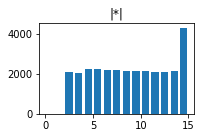

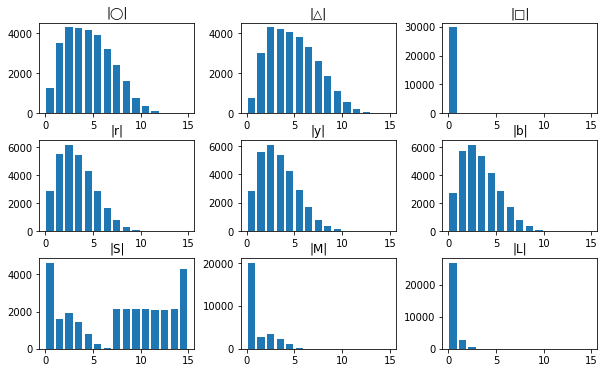

<IPython.core.display.Javascript object>

In [29]:
#@title Test set { run: "auto", vertical-output: true }
test_generator.panda.display_meta(test_params['figure_parameters'])



shape= (29867, 19)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle', 'triangle'],
}

Max |r| in training set= 12

Class names= ['0 red ◯' '1 red ◯' '2 red ◯' '3 red ◯' '4 red ◯' '5 red ◯']

sklearn classweights=  [0.69444444 0.41666667 0.75757576 2.08333333 5.55555556 5.55555556]

Panda info=
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29867 entries, 0 to 29976
Data columns (total 19 columns):
BID          29867 non-null int64
BPOS         29867 non-null int64
ID           29867 non-null object
Yreadable    29867 non-null object
enc|r|       29867 non-null object
enc|r◯|      29867 non-null object
enc|y|       29867 non-null object
file         29867 non-null object
|*|          29867 non-null int64
|L|          29867 non-null int64
|M|          29867 non-null int64
|S|          29867 non-null int64
|b|          29867 non-null int64
|r|          29867 non-null int64
|r◯|         29867 non-null int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

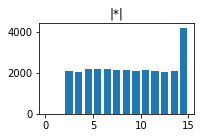

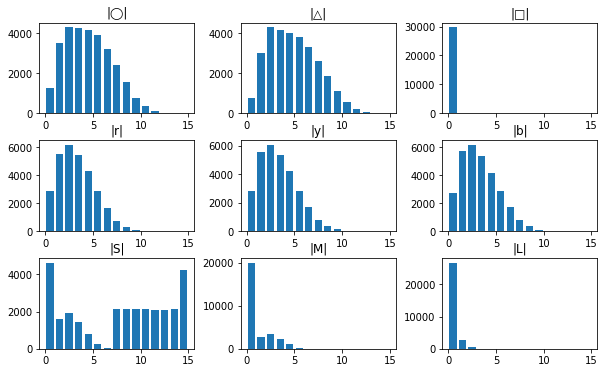

<IPython.core.display.Javascript object>

In [30]:
#@title Use same filter for test set { run: "auto", vertical-output: true }

tpf = filter_panda(test_generator.panda.f)
test_filtered = PandaSet(
    tpf, 
    test_generator,
    rowidx_sync_generator = FilterByFrameGenerator(test_generator, tpf)
)
test_filtered.display_meta(test_params['figure_parameters'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

BID  BPOS              ID Yreadable  ... |y| |□| |△| |◯|
0    0     0  test/fig000000   1 red ◯  ...   0   0   4   4
1    0     1  test/fig000001   2 red ◯  ...  10   0   7   7
2    0     2  test/fig000002   3 red ◯  ...   5   0   4   8

[3 rows x 19 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

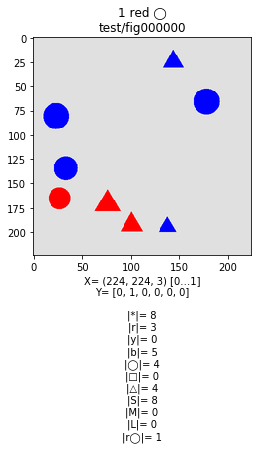

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

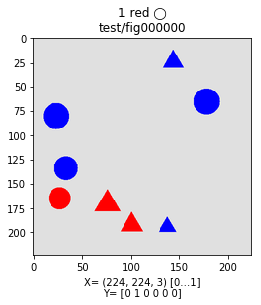

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

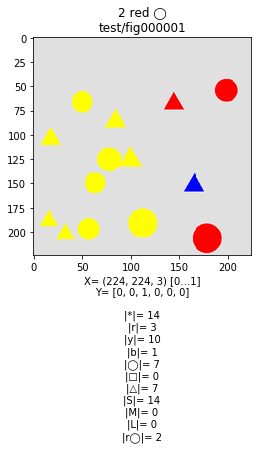

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

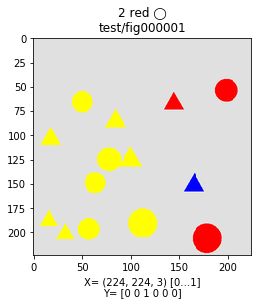

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

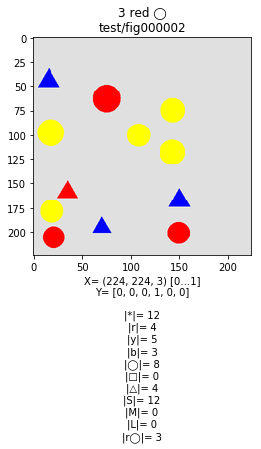

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

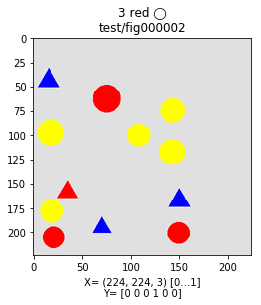

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
#@title Review Train Generator { run: "auto", vertical-output: true }

sample_to_view  = 0 #@param {type:"slider", min:0, max:20000, step:1}
view_len = 3 #@param {type:"slider", min:1, max:20, step:1}

test_filtered.display_content_slice(
    slice(sample_to_view, sample_to_view + view_len),
    assert_view = lambda s, r, ridx, g, sg: s.plot(        
        X=g[r['BID']][0][r['BPOS']], 
        Y=g[r['BID']][1][r['BPOS']]
    )
)

# Evaluation 1

In [32]:
#@title Test Metrics { run: "auto", vertical-output: true }

used_test_generator = test_filtered.generator
used_test_panda = test_filtered

print("Accuracy %s" % new_model.evaluate_generator(used_test_generator, verbose=1)[1])

963/963 [==============================] - 159s 165ms/step - loss: 0.0104 - categorical_accuracy: 0.9998
Accuracy 0.9998325


In [35]:
#@title Predict and add Prediction to panda { vertical-output: true }

y_pred = new_model.predict_generator(used_test_generator, verbose=1)
#y_pred_nr = np.argmax(y_pred, axis=1)
#y_pred_str = ['%d red circles'%nr for nr in y_pred_nr]
y_pred_str = [decodeY(hot) for hot in y_pred]

raw_panda = used_test_panda.iloc[0:len(y_pred_str)].copy()
raw_panda['Ypredicted'] = y_pred_str

mask = (raw_panda['Yreadable'] != raw_panda['Ypredicted'])

print("\nnumber of falsy predictions", np.sum(mask))
print("\nnumber of correct predictions", np.sum(~mask))

raw_panda['mask'] = mask



963/963 [==============================] - 155s 161ms/step

number of falsy predictions 5

number of correct predictions 29848



shape= (5, 21)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle', 'triangle'],
}

Max |r| in training set= 9

Class names= ['4 red ◯' '5 red ◯']

sklearn classweights=  [0.69444444 0.41666667 0.75757576 2.08333333 5.55555556 5.55555556]

Panda info=
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 19077 to 27741
Data columns (total 21 columns):
BID           5 non-null int64
BPOS          5 non-null int64
ID            5 non-null object
Yreadable     5 non-null object
enc|r|        5 non-null object
enc|r◯|       5 non-null object
enc|y|        5 non-null object
file          5 non-null object
|*|           5 non-null int64
|L|           5 non-null int64
|M|           5 non-null int64
|S|           5 non-null int64
|b|           5 non-null int64
|r|           5 non-null int64
|r◯|          5 non-null int64
|y|           5 non-null int64
|□|           5 non-null int64
|△|           5 non-null

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

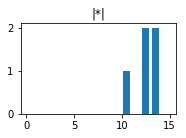

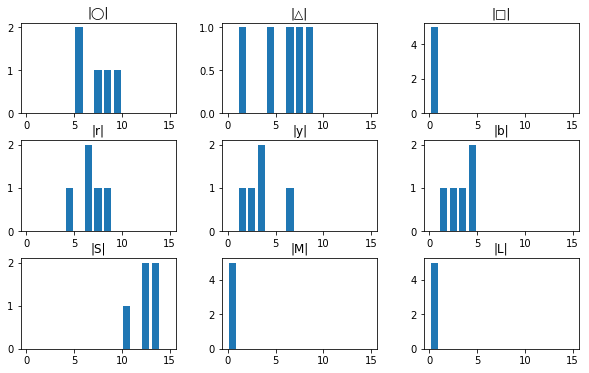

<IPython.core.display.Javascript object>

In [36]:
#@title Create Set of Errors { vertical-output: true }

error_set = PandaSet(
    raw_panda[mask], 
    used_test_generator,
    rowidx_sync_generator = FilterByFrameGenerator(used_test_generator, raw_panda[mask])
)

error_set.display_meta(test_params['figure_parameters'])    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

BID  BPOS              ID Yreadable  ... |△| |◯| Ypredicted  mask
19077  615    12  test/fig019077   4 red ◯  ...   7   5    3 red ◯  True
20797  670    27  test/fig020797   4 red ◯  ...   8   5    3 red ◯  True
23057  743    24  test/fig023057   5 red ◯  ...   6   7    4 red ◯  True
25482  822     0  test/fig025482   5 red ◯  ...   4   8    4 red ◯  True
27741  894    27  test/fig027741   4 red ◯  ...   1   9    5 red ◯  True

[5 rows x 21 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

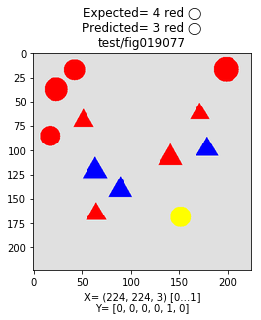

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

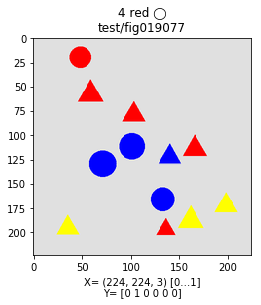

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

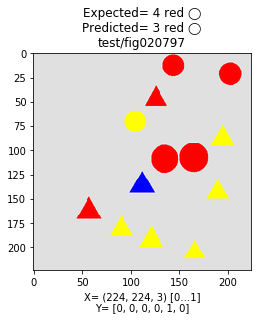

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

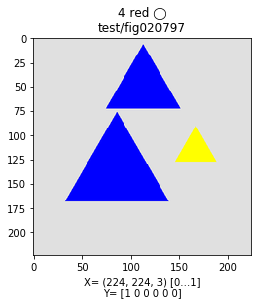

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

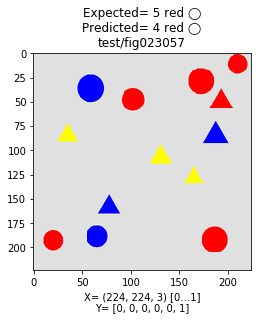

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

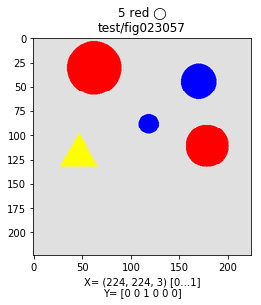

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

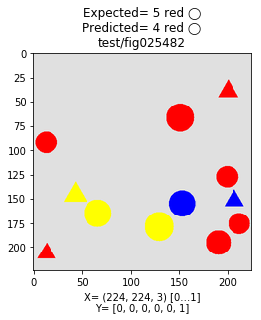

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

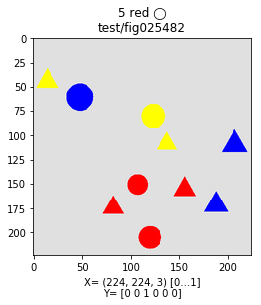

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

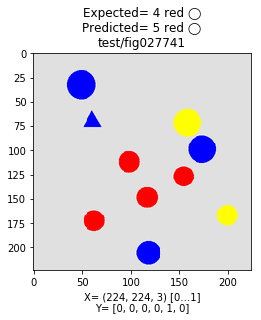

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

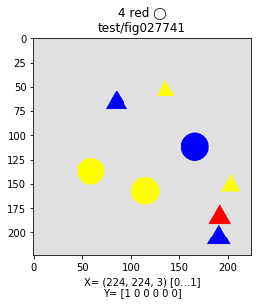

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
#@title View Error Samples { run: "auto", vertical-output: true } 
sample_to_view  = 0 #@param {type:"slider", min:0, max:2000, step:1}
view_len = 5 #@param {type:"slider", min:1, max:25, step:1}

error_set.display_content_slice(
    slice(sample_to_view, sample_to_view + view_len), 
    sample_view = lambda s, r: s.plot(verbose=0, title_prefix = "Expected= %s\nPredicted= %s"%(r['Yreadable'], r['Ypredicted'])), 
    assert_view = lambda s, r, ridx, g, sg: s.plot(        
        X=g[r['BID']][0][r['BPOS']], 
        Y=g[r['BID']][1][r['BPOS']]
    )
    #Xassert = 
    #Yassert = 
)

In [0]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):    
    cm = confusion_matrix(y_true=cls_test, y_pred=cls_pred) 

    print("Confusion matrix:")        
    print(cm)    
    
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [0]:
#https://colab.research.google.com/notebooks/charts.ipynb#scrollTo=8YCVGqZkJJxT

def enable_plotly_in_cell():
    import IPython
    from plotly.offline import init_notebook_mode
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
    '''))
    init_notebook_mode(connected=False)

In [40]:
from plotly.offline import iplot
import plotly.graph_objs as go

enable_plotly_in_cell()

data = [
    go.Contour(
        z=[[10, 10.625, 12.5, 15.625, 20],
           [5.625, 6.25, 8.125, 11.25, 15.625],
           [2.5, 3.125, 5., 8.125, 12.5],
           [0.625, 1.25, 3.125, 6.25, 10.625],
           [0, 0.625, 2.5, 5.625, 10]]
    )
]
iplot(data)